<a href="https://colab.research.google.com/github/dr4gon01/ML-Pojects/blob/main/Stable_Diffusion_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers transformers accelerate torch

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# 1.choose a specific version of the model ("The Artist")
model_id = "runwayml/stable-diffusion-v1-5"


# 2. Load the pipeline
# torch_dtype=torch.float16 reduced memory usage by half without losing much quality
pipe =  StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)


#3. Moving the whole process to GPU accelerator
pipe = pipe.to("cuda")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

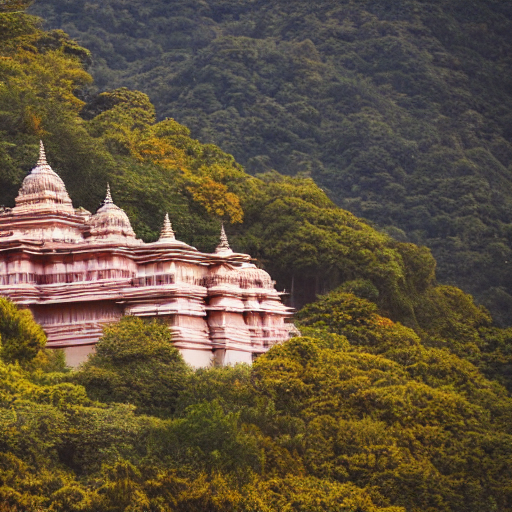

In [ ]:
##
prompt = "a Hindu temple on a hill" #uses a text encoder called CLIP

image = pipe(prompt).images[0] #by default 50 steps

#displayed image looks photorealistic as the model version 1.5 is trained on massive real world photos
image

It converts the word into a list of numbers.This list of numbers is called an Embedding (or Vector). It works like a GPS coordinate in a massive multi-dimensional map of concepts."King" has a coordinate."Man" has a coordinate."Woman" has a coordinate.The magic of these embeddings is that you can do math with them:$$King - Man + Woman = Queen$$

In [ ]:
#Looking through the lens of the model: What does the model see when we type "Hindu Temple"

#1. turn text into tokens (IDS)
text_inputs = pipe.tokenizer(["a Hindu temple"], return_tensors="pt" )

print("raw token ids:", text_inputs.input_ids)
#2. turn tokens into embeddings
# we need to manually load the text encoder part of the pipeline to see this
text_embeddings = pipe.text_encoder(text_inputs.input_ids.to("cuda"))[0]

print(f"\nShape of Embeddings: {text_embeddings.shape}")


raw token ids: tensor([[49406,   320, 12053,  5620, 49407]])

Shape of Embeddings: torch.Size([1, 5, 768])


# Output Interpretation:

49406: The "Start of Text" flag.

320, 12053, 5620: The IDs for "a", "hindu", "temple".

49407: The "End of Text" flag.

So, you have 5 tokens, and each one is described by a list of 768 numbers (coordinates).

# The VAE (Variational Autoencoder)
is the translator between "Pixel World" (what humans see) and "Latent World" (what the U-Net fixes).

VAE Encoder: Compresses the massive 512x512 pixel image into a dense, mathematical summary.

U-Net: Does the heavy lifting (denoising) on that small summary.

VAE Decoder: Takes the clean summary and expands it back into pixels, hallucinating the fine textures (like stone or grass) that were compressed away.

The "Latent" Dimensions
This compression is the main reason Stable Diffusion is fast enough to run on a home computer. It shrinks the image dimensions by a factor of 8.

In [ ]:
print(f"VAE Scale Factor: {pipe.vae_scale_factor}")

VAE Scale Factor: 8


# The Final Component: The Scheduler (The Timekeeper)

We have the Artist (U-Net), the Translator (Text Encoder), and the Compressor (VAE).

But if you remember our "Castle" experiment, I mentioned the model takes 50 steps to clean the image. Who decides how much noise to remove at step 1 versus step 49?

That is the job of the Scheduler.

Forward Process (Training): The scheduler decides how much noise to add at each timestep to destroy the image.

Reverse Process (Generation): The scheduler provides the "recipe" for removing that noise.

Different schedulers have different "personalities." Some are slow and precise (like LMSDiscrete), while others are fast and approximate (like EulerAncestral).

In [ ]:
print(f"Current Scheduler: {pipe.scheduler.config._class_name}")

Current Scheduler: PNDMScheduler


Generating Universe A (Reality)...


  0%|          | 0/50 [00:00<?, ?it/s]

Generating Universe B (The Future)...


  0%|          | 0/50 [00:00<?, ?it/s]


--- The Reality ---


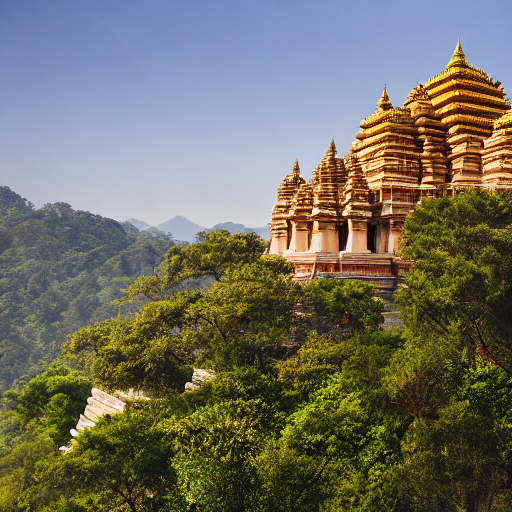


--- The Parallel Universe ---


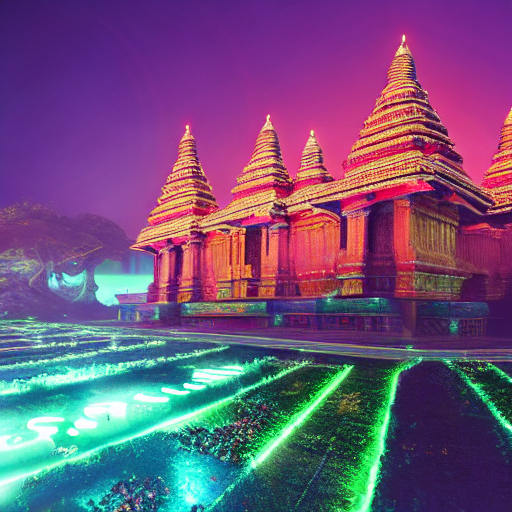

In [ ]:
import torch
from IPython.display import display

# 1. Pick a specific "Seed" (The DNA of the image layout)
# Changing this number changes the random noise pattern
seed = 8000

# 2. Define the "Negative Prompt" (The Banned List)
# We tell the math: "Steer away from these concepts"
neg_prompt = "blurry, cartoon, low quality, watermark, text, ugly"

# 3. Universe A: The Classic
# We create a generator with our seed
generator_a = torch.Generator("cuda").manual_seed(seed)
prompt_a = "A majestic hindu temple on a hill, photorealistic, 8k, cinematic lighting, national geographic"

print("Generating Universe A (Reality)...")
image_a = pipe(prompt_a, negative_prompt=neg_prompt, generator=generator_a).images[0]

# 4. Universe B: The Cyberpunk Remix
# We use the EXACT same seed to get the same noise layout
generator_b = torch.Generator("cuda").manual_seed(seed)
prompt_b = "A majestic hindu temple on a hill, cyberpunk, neon lights, futuristic, sci-fi, blade runner style, purple and blue glow"

print("Generating Universe B (The Future)...")
image_b = pipe(prompt_b, negative_prompt=neg_prompt, generator=generator_b).images[0]

# Display
print("\n--- The Reality ---")
display(image_a)
print("\n--- The Parallel Universe ---")
display(image_b)

In [ ]:
import torch
import gc
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers.utils import export_to_video

# 1. Clean up the old model to free up VRAM (Important!)
if 'pipe' in globals():
    del pipe
torch.cuda.empty_cache()
gc.collect()

# 2. Load the Video Pipeline (The Director)
model_id = "damo-vilab/text-to-video-ms-1.7b"
pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")

# 3. Optimize for low memory (Offloads parts to CPU when not in use)
pipe.enable_model_cpu_offload()
pipe.enable_vae_slicing()

print("🎥 Director is on set and ready!")

model_index.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/755 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/2.82G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

The TextToVideoSDPipeline has been deprecated and will not receive bug fixes or feature updates after Diffusers version 0.33.1. 


🎥 Director is on set and ready!


/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/pipeline_utils.py:2186: FutureWarning: `enable_vae_slicing` is deprecated and will be removed in version 0.40.0. Calling `enable_vae_slicing()` on a `TextToVideoSDPipeline` is deprecated and this method will be removed in a future version. Please use `pipe.vae.enable_slicing()`.
  deprecate(


In [ ]:
from IPython.display import Video

# 1. Define the scene
prompt = "A majestic hindu temple on a hill, cinematic lighting, national geographic, drone shot, 4k"
neg_prompt = "text, watermark, copyright, blurry, nsfw, noise, quick motion, distorted"

# 2. Shoot the video (16 frames)
print("🎥 Shooting scene... this usually takes 1-2 mins...")
video_frames = pipe(prompt, negative_prompt=neg_prompt, num_frames=16).frames[0]

# 3. Save the video file
video_path = export_to_video(video_frames, "temple_scene.mp4")

# 4. Display
print("\n--- Final Cut ---")
Video("temple_scene.mp4", embed=True, width=512)

🎥 Shooting scene... this usually takes 1-2 mins...


  0%|          | 0/50 [00:00<?, ?it/s]


--- Final Cut ---
